# Grover Search for Portfolio Selection
We explore the quantum version of selecting list items by
a given condition, also known as (list) slicing by condition.
Here, the list items are numbers and we are interested in
taking list elements larger/smaller than a given number. By
means of binary search, the proposed method can be used as
a maximum/minimum function.

Consider that the efficient frontier of a portfolio universe is
calculated and presented to an investor, who would like to
choose portfolios among these optimal ones. More specifically,
it would be two lists of numbers, where one is the list
of returns and the other the list of corresponding standard
deviations of the optimal portfolios. In this case, Quantum Exponential Search
can be used to do the filtering that maximizes
the investor’s preferences, e.g. "pick portfolios with return
larger than x% and standard deviation less than y". Another
case would be picking the portfolio with the best sharpe ratio,
which is achieved by employing Grover Adaptive Search.

## Import Libraries

In [1]:
import sys

import math

import numpy as np

from utils.gates import GreaterThanGate,LessThanGate
from utils.algorithms.grover import mQCS,GAS
from utils.algorithms.counting import get_count
from matplotlib import pyplot as plt

np.random.seed(1)

## Data

### Importing Efficient Frontier

Text(0.5, 1.0, 'Efficient Frontier')

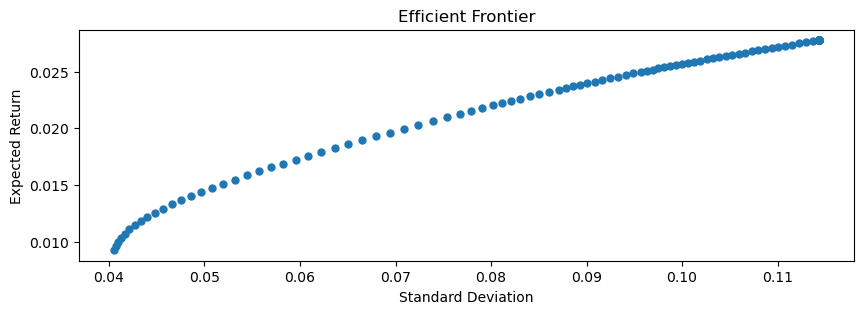

In [2]:
# 10 assets
optimal_risk_return_pairs = np.load('./return_risk_for_QAIF.npy')
returns, risks = optimal_risk_return_pairs.transpose()
risks = np.sqrt(risks)

plt.figure(figsize=(10, 3))
plt.plot(risks, returns, 'o', markersize=5)
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')

### Subsample data
We take subsamples from the actual data because the number of qubits required to hold all the values is too high in terms of the required memory.

In [3]:
n_iqb = 3 # Number of index qubits

N = 2**n_iqb
returns, risks = optimal_risk_return_pairs.transpose()
risks = np.sqrt(risks)
subsample_complete = False
while not subsample_complete:
    subsample_indices = np.random.choice(len(returns),N)
    subsample_complete = np.unique(subsample_indices).size == subsample_indices.size
returns = returns[subsample_indices]
risks = risks[subsample_indices]

### Risks and Returns

In [4]:
print(risks)
print(returns)

[0.08015615 0.04755195 0.1065935  0.0448151  0.10867272 0.04211789
 0.11151044 0.1012755 ]
[0.02201008 0.01364281 0.02667475 0.0125437  0.02697515 0.01107822
 0.02737567 0.0258737 ]


## Experiments

### 1) Find portfolios with returns more than $r_{threshold}$ and standard deviation less than $\sigma_{threshold}$.

This is a Conditional Slicing problem with two lists and conditions. We solve it with $\textbf{Quantum Exponential Search}$.

In [5]:
d = 0.01 #resolving power of GT-gate
r_threshold = 0.02
sigma_threshold= 0.11
##############

N = 2**n_iqb
t = math.ceil(-math.log2(d)) # for greater-than / phase estimation

assert np.any(returns>r_threshold)
assert np.any(risks<sigma_threshold)
solutions = np.where((returns>r_threshold)*(risks<sigma_threshold))[0].tolist()
no_of_solutions = len(solutions)
print('(Classical) Solutions with indices:', solutions,'O(sqrt(N/M))=',np.sqrt(N/no_of_solutions))

f_check = lambda x: (returns[x]>r_threshold)*(risks[x]<sigma_threshold)

index_,_ = mQCS([returns,risks],[r_threshold,sigma_threshold],[GreaterThanGate(t),LessThanGate(t)],f_check=f_check)

print(f'(Quantum) Solution:{index_}')

(Classical) Solutions with indices: [0, 2, 4, 7] O(sqrt(N/M))= 1.4142135623730951
(Quantum) Solution:4


### 2) Find portfolios with the best Sharpe ratio.

We find the maximum value using $\textbf{Grover Adaptive Search}$.

In [6]:
sharpes = returns/risks
sharpes

array([0.27459001, 0.28690324, 0.25024746, 0.27989898, 0.24822371,
       0.2630289 , 0.24549872, 0.25547841])

In [7]:
print('(Classical) Maximum Sharpe Ratio:', sharpes.max(),'with index',np.where(sharpes==sharpes.max())[0].item())
print(f'(Quantum) Solution:{GAS(sharpes,d)}')

(Classical) Maximum Sharpe Ratio: 0.28690324462564365 with index 1
(Quantum) Solution:1
